# Description
Use Approximative Baysian Computation to fit $b1$ and $\beta$ to model. Reduced $\chi^2$ was chosen as a distance function. See `Fit_b1_beta_minchi2.ipynb` for more elementary approach to same fitting task as well as some background discussion. 

In ABC would need to compute inverse covariance matrix i.e. estimate for measurement error many times (for each candidate value of b1, beta). So speed up the computation, compute the covariance matrix not based on the linear model, but on the data. This removes the b1, beta dependence and only introduces an error of an error which can be ignored in light of the desired accuracy of this analysis. This is implemented according to https://arxiv.org/pdf/1509.04293.pdf equation 24 and stored in `Pkmus`.

When trying to use `Pkmus[i] = r.power['mu']` as the i-th percentile data $P(k,\mu)$ to estimate the covariance matrix, issues occur as a lot of elements are NaN (when no Fourier modes can contained in a k,mu bin to average the power over). Above alternative of using combination of multipoles weighted by Legendre polynomials works fine.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
from scipy.special import legendre, spherical_jn
from scipy.integrate import simpson, quad
from scipy.linalg import pinv
import scipy.sparse as ss
from scipy.stats import bayes_mvs

import cat_power_algos as catpk
import classylss
import fitsio
from nbodykit.lab import *
from nbodykit import style, setup_logging
#setup_logging()
plt.style.use(style.notebook)

In [3]:
LOS = [0,0,1]
redshift = 0
BoxSize = 2000
cosmo_paras = classylss.load_ini('Planck18_LCDM.ini')
cosmo = cosmology.cosmology.Cosmology.from_dict(cosmo_paras)
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu') # matter power spectrum 

dk = 0.01

/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): sigma_8, w0_fld, wa_fld
  self.engine = ClassEngine(pars)
/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): sigma_8
  self.engine = ClassEngine(pars)


In [4]:
# load computed power spectra
ptile_split = np.loadtxt('density_bins/percentile_edges.txt')

ells = [0,2]
n_ptile = len(ptile_split)-1 # number of bins = number of edges - 1
Pkmus = np.empty(n_ptile, dtype='object') # contains P(k,mu) as 2D array of shape (#k, #mu) for each percentile
Pk_ells = np.empty((n_ptile, len(ells)), dtype='object') # each column contains multipole of all percentiles

for i in range(n_ptile):
    r = FFTPower.load('density_bins/ptile_%d.json'%i)
    poles = r.poles 
    mus = r.power.coords['mu']
    
    Pkmu_nl = np.zeros((len(poles['k']), len(mus)))
    for j,ell in enumerate(ells):
        Pk_ell = poles['power_%d' %ell].real
        if ell == 0: 
            Pk_ell = Pk_ell - poles.attrs['shotnoise']
            
        Pk_ells[i][j] = Pk_ell
        Pkmu_nl += np.outer(Pk_ell, legendre(ell)(mus))
        
    Pkmus[i] = Pkmu_nl

k = poles['k']
shotnoise = poles.attrs['shotnoise']

In [5]:
def sigma_8(k, b1):
    '''Computes sigma8 assuming linear matter power spectrum. 
    Follows https://physics.stackexchange.com/questions/521471/formula-to-compute-sigma8-for-correction-in-non-linear-regime and
    https://nbodykit.readthedocs.io/en/latest/api/_autosummary/nbodykit.cosmology.power.linear.html?highlight=Spectra.sigma8#nbodykit.cosmology.power.linear.LinearPower.sigma_r'''
    window = lambda x: 3*spherical_jn(1,x)/x
    integrand = lambda k: window(8*k)**2 * b1**2 * Plin(k)
    return 1/(2*np.pi**2) * quad(integrand, 1e-5, 10)


def per_mode_cov(k, mus, Pkmu, l1, l2, shotnoise, dk):
    '''Construct per mode covariance. See eq 15, 16 (for factor f) of Grieb et al. (2016).'''
    V = BoxSize**3
    V_k = 4/3*np.pi*((k+dk/2)**3 - (k-dk/2)**3)
    f = 2*(2*np.pi)**4 / V_k**2 * k**2 * dk
    L_l1, L_l2 = legendre(l1)(mus), legendre(l2)(mus)
    integrand = (Pkmu + shotnoise)**2 * L_l1*L_l2
    
    return f*(2*l1+1)**2 * (2*l2+1)**2 / V * simpson(integrand, mus) # 1D array containing per mode cov for each k bin


def gaussian_cov_mat_inv(k, mus, Pkmu, ells, shotnoise, dk):
    '''See above markdown for explanation of structure of covariance matrix. Uses sparse matricies for fast inversion.
    scipy.sparse.bmat allows to combine matricies by passing structure of larger matrix in terms of submatricies.'''
    # initialize array accepting matricies as elements and fill with diagonal C_l1,l2 matricies
    C = np.empty((len(ells), len(ells)), dtype='object')
    for i,l1 in enumerate(ells):
        for j,l2 in list(enumerate(ells))[i:]:
            C[i][j] = ss.diags(per_mode_cov(k,mus,Pkmu,l1,l2,shotnoise,dk))
            if j!=i:
                C[j][i] = C[i][j]
                
    cov_mat = ss.bmat(C).tocsc() # convert to efficient scipy matrix format
    
    # deal with inverting signular matrix
    try: 
        inv = ss.linalg.inv(cov_mat).toarray()
    except RuntimeError:
        inv = pinv(cov_mat.toarray())
        
    return inv
    
    
def chi2(x, k, data_multipoles, shotnoise, dk, C_inv):
    '''Find chi^2 as explained in Fitting_b1.ipynb. data_multipoles must be an array of shape (len(ells), len(k)).
    x is an array containing the parameters to be fitted: x = [b1, beta].
    Due to hard coding multipoles, only works for ells = [0,2]'''
    b1, beta = x[0], x[1]
    ells = [0,2]
    # make model vector
    model_multipoles = np.empty((len(ells), len(k)))
    model_multipoles[0] = (1 + 2/3*beta + 1/5*beta**2) * b1**2 * Plin(k)
    model_multipoles[1] = (4/3*beta + 4/7*beta**2) * b1**2 * Plin(k)
        
    D_M = (data_multipoles - model_multipoles).flatten()
    
    return D_M@(C_inv @ D_M)

In [6]:
def ABC(k, data_multipoles, nreps, ranges, epsilon, C_inv):
    """Perfrom Approximate Bayesian computation with uniform priors.
    
    Parameters
    ----------
    k : array
        Mid point of k bins upto which we seek to fit the model to the data.
    data_multipoles: 
        2D array of shape (number multipoles, length k) containing multipole data for all k.
    nreps : int
        The number of trials.
    ranges : list of tupels of floats
        Each tuple defines the bounds of the model parameter range.
    epsilon : float
        The maximum distance for a model to be accepted.

    Returns
    -------
    selected : array
        Parameters of the accepted models.
    acc_rate : float
        acceptance rate in percent
    """
    selected = []

    t1 = time.time()
    for i in range(nreps):
        # create trial parameters from uniform prior.
        pars = [np.random.uniform(*r) for r in ranges]
        # Take reduced chi2 as distance meassure
        dist = chi2(pars, k, data_multipoles, shotnoise, dk, C_inv) / (2*len(k)-2)
        
        if dist < epsilon:
            selected.append(pars)
            
    t2 = time.time()
    #print("Epsilon=%.2f, time:%.2f sec"%(epsilon,t2-t1))
    
    return np.array(selected), len(selected)/nreps*100

In [11]:
# arrays full of NaN. When not enough candidates accepted, NaN remains and percentile will not be plotted
b1_fits, beta_fits = np.full(n_ptile, np.nan), np.full(n_ptile, np.nan) # mean of accepted parameters
b1_cred, beta_cred = np.full((n_ptile,2), np.nan), np.full((n_ptile,2), np.nan) # 3 sigma credibility interval
reduced_chi2 = np.full(n_ptile, np.nan) # reduced chi at mean of accepted parameters 

ranges = [(0,3), (-1,2)]
reps = int(5e4)

for i in range(n_ptile):
    t1 = time.time()
    # change data format of Pk_ells to be compatible with chi2 minimization code 
    data_multipoles = np.zeros((len(ells), len(k)))
    data_multipoles[0] = Pk_ells[i][0]
    data_multipoles[1] = Pk_ells[i][1]
    
    C_inv = gaussian_cov_mat_inv(k, mus, Pkmus[i] , ells, shotnoise, dk)
    sel, acc = ABC(k, data_multipoles, reps, ranges, 2, C_inv)
    
    if len(sel) < 2: # for bayes_mvs to work properly
        print("Not enough accepted values in percentile %d. Increase epsilon"%i)
        continue
    # gets mean the the 3 sigma credibility interval. Returns similar results for variance and std
    b1_stats, _, _ = bayes_mvs(sel[:,0], alpha=0.997) 
    beta_stats, _, _ = bayes_mvs(sel[:,1], alpha=0.997)
    b1_fits[i], b1_cred[i][0], b1_cred[i][1] = b1_stats[0], b1_stats[1][0], b1_stats[1][1]
    beta_fits[i], beta_cred[i][0], beta_cred[i][1] = beta_stats[0], beta_stats[1][0], beta_stats[1][1]
    reduced_chi2[i] = chi2([b1_fits[i], beta_fits[i]], k, data_multipoles, shotnoise, dk, C_inv) / (2*len(k)-2)
    
    t2 = time.time()
    print("Fitted %d-th percentile (acceptance rate: %.2f%%) in %.2f sec"%(i+1,acc,t2-t1))

Fitted 1-th percentile (acceptance rate: 0.04%) in 10.09 sec
Fitted 2-th percentile (acceptance rate: 0.01%) in 10.14 sec
Fitted 3-th percentile (acceptance rate: 0.12%) in 10.05 sec
Fitted 4-th percentile (acceptance rate: 0.29%) in 10.01 sec
Fitted 5-th percentile (acceptance rate: 0.28%) in 10.41 sec
Fitted 6-th percentile (acceptance rate: 0.34%) in 10.06 sec
Fitted 7-th percentile (acceptance rate: 0.29%) in 10.18 sec
Fitted 8-th percentile (acceptance rate: 0.55%) in 10.36 sec
Fitted 9-th percentile (acceptance rate: 0.30%) in 10.02 sec
Not enough accepted values in percentile 9. Increase epsilon


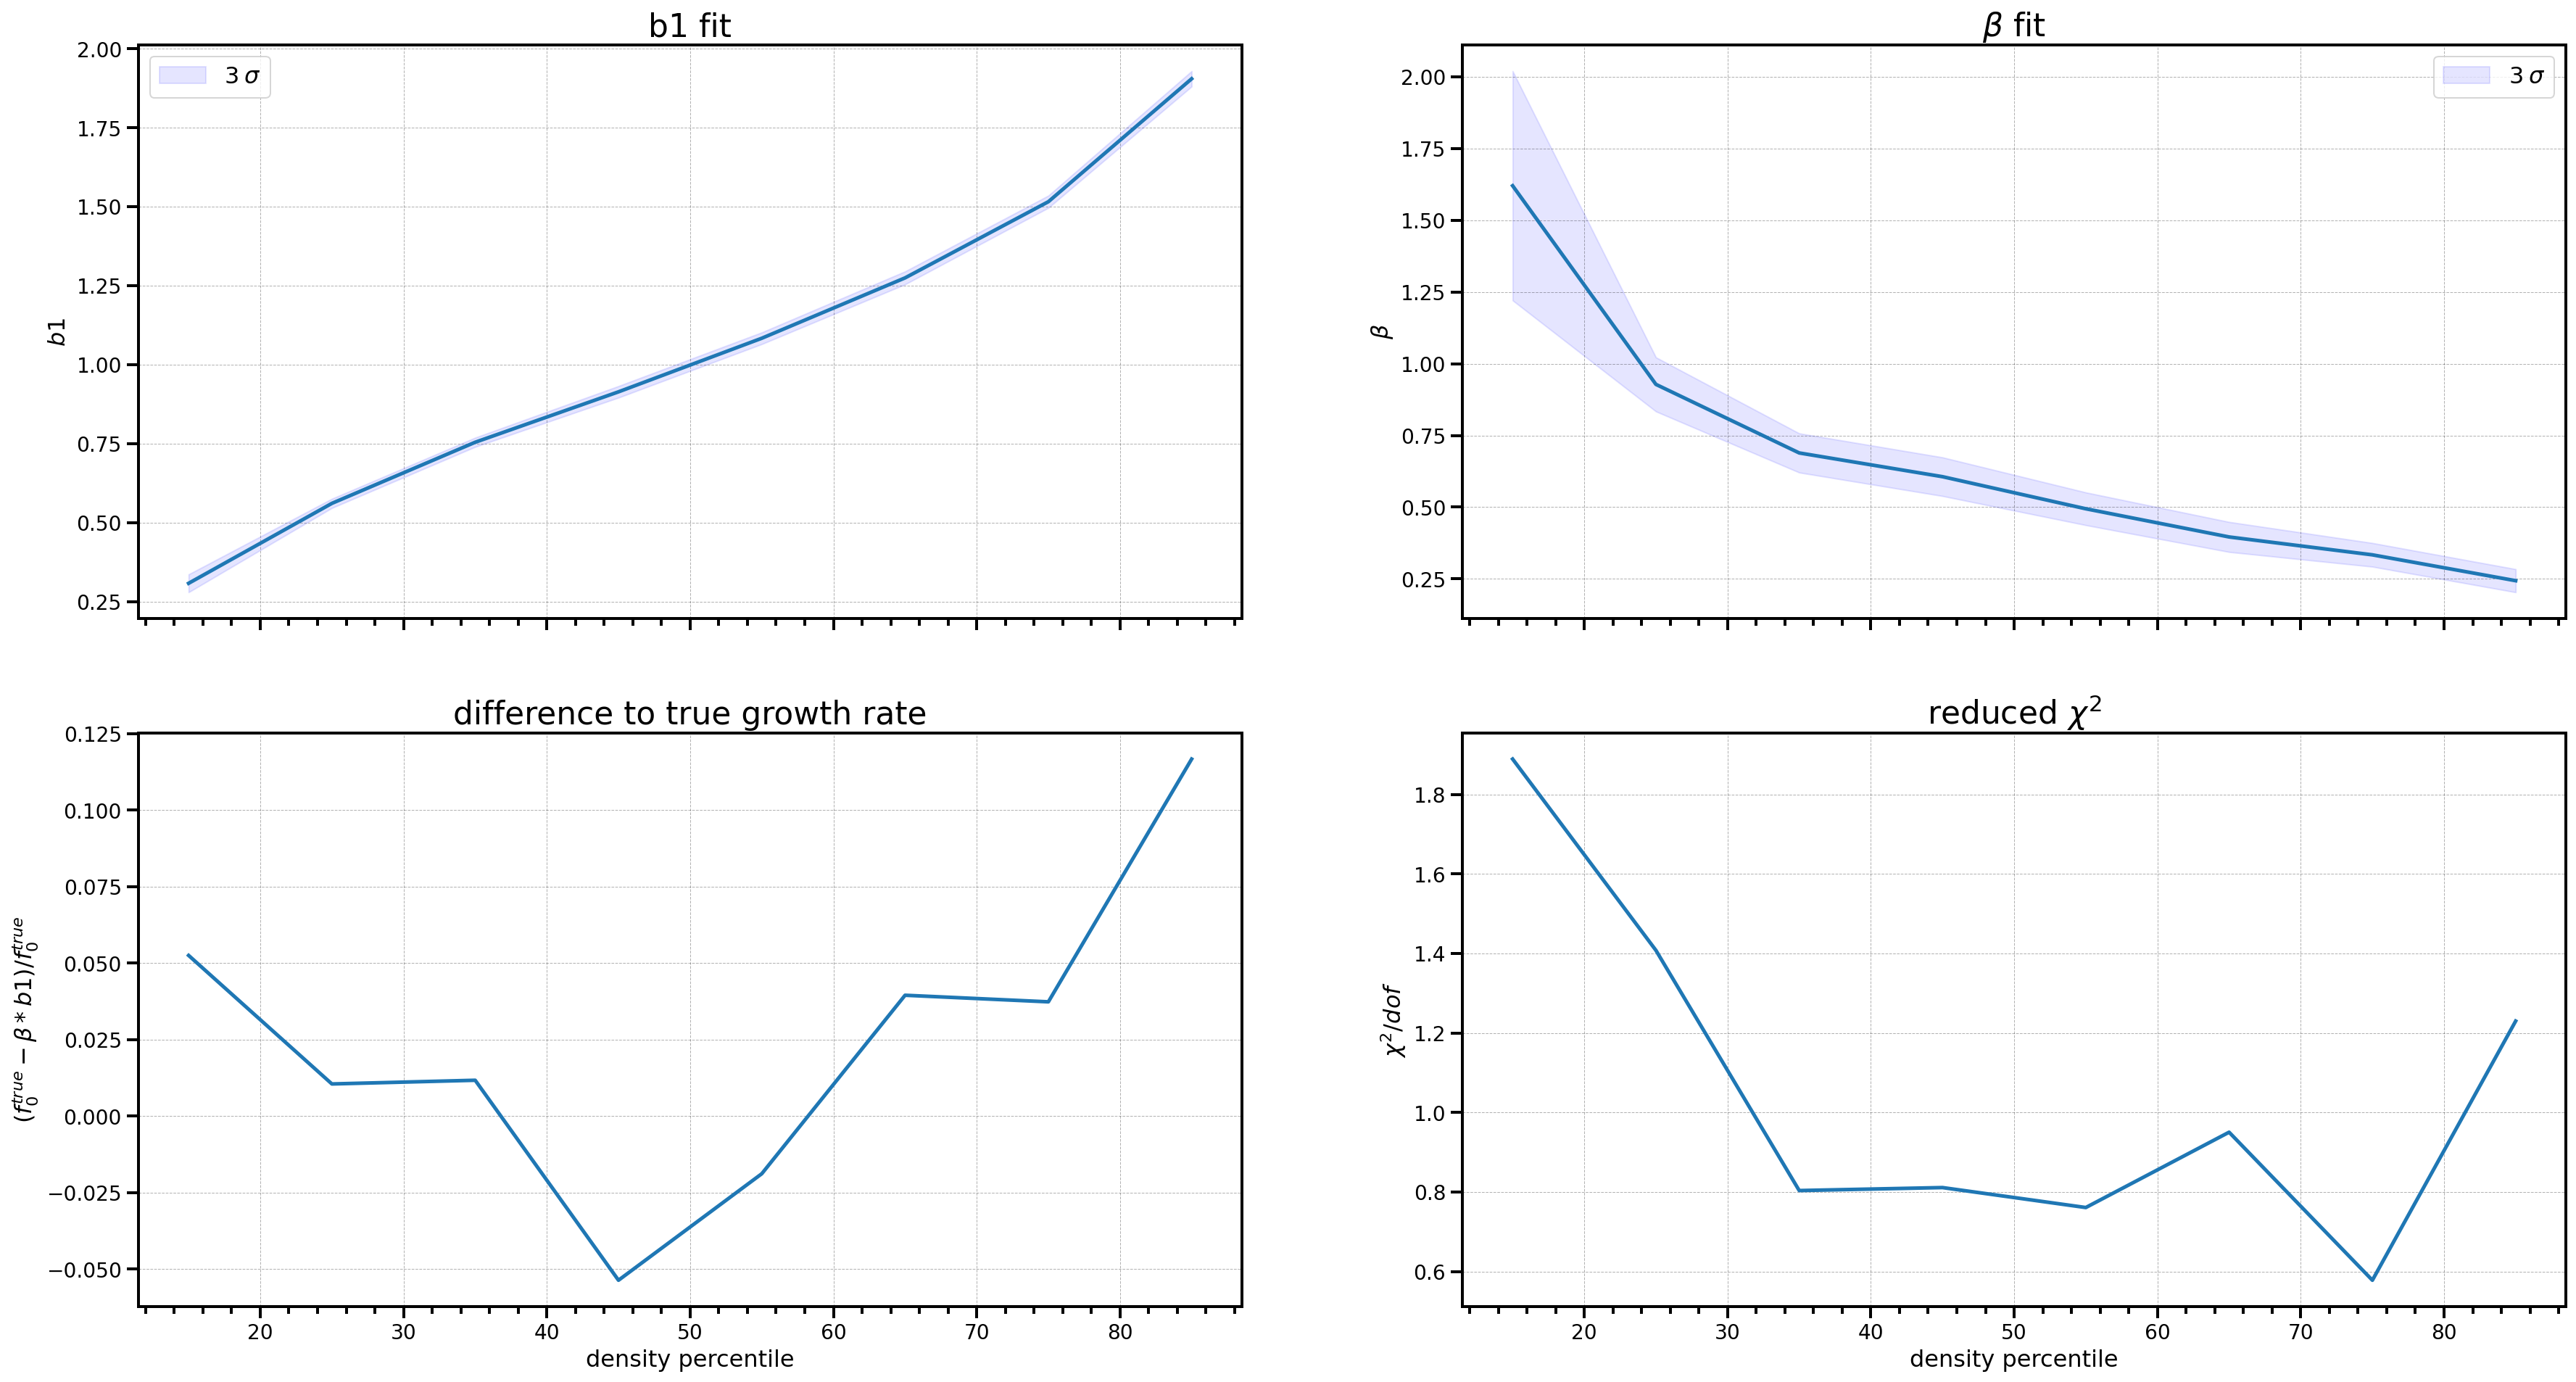

In [36]:
from matplotlib.ticker import AutoMinorLocator
fig, axs = plt.subplots(2, 2, figsize=(30,16), sharex=True)

mids = np.arange(5,105,10)[1:] # percentile mid points

axs[0][0].plot(mids, b1_fits[1:])
axs[0][0].fill_between(mids, b1_cred[:,0][1:], b1_cred[:,1][1:], color='b', alpha=0.1, label=r'$3 \: \sigma$')
axs[0][0].set_title("b1 fit")
axs[0][0].set_ylabel(r"$b1$")
axs[0][0].legend()

axs[0][1].plot(mids, beta_fits[1:])
axs[0][1].fill_between(mids, beta_cred[:,0][1:], beta_cred[:,1][1:], color='b', alpha=0.1, label=r'$3 \: \sigma$')
axs[0][1].set_title(r"$\beta$ fit")
axs[0][1].set_ylabel(r"$\beta$")
axs[0][1].legend()

f0_true = cosmo.scale_independent_growth_rate(redshift)
delta_f = (f0_true - (beta_fits*b1_fits)) / f0_true
#delta_f_cred = (b1_cred.T*beta_fits+b1_fits*beta_cred.T) / f0_true
axs[1][0].plot(mids, delta_f[1:])
#axs[1][0].fill_between(mids, delta_f_cred[0][1:], delta_f_cred[1][1:], color='b', alpha=0.1, label=r'$3 \: \sigma$')
axs[1][0].set_title(r"difference to true growth rate")
axs[1][0].set_xlabel("density percentile")
axs[1][0].set_ylabel(r"$(f^{true}_0 - \beta*b1)/f^{true}_0$")
axs[1][0].xaxis.set_minor_locator(AutoMinorLocator())

axs[1][1].plot(mids, reduced_chi2[1:])
axs[1][1].set_title("reduced $\chi^2$")
axs[1][1].set_xlabel("density percentile")
axs[1][1].set_ylabel(r"$\chi^2 / dof$")
axs[1][1].xaxis.set_minor_locator(AutoMinorLocator())

plt.show()
#fig.savefig('plots/Fitting_b1_beta_densitybins_ABC.pdf')

### Interpretation
The ball park of the fitted parameter is similar to the one found in the fitting via minimizing chi2. The issue with the first percentile remains: The quadrupole moment is entirely negative such that a negative beta is fitted which gives a good chi2 but a wrong f0.

The estimated f0 is better in this fit is better compared to the one from minimizing chi2. There still is a tendency to underestimate f0. 